<h1>Programming Assignment Chapter 4</h1>


University of Puerto Rico - Mayaguez

Department of Electrical and Computer Engineering

ICOM5015 Inteligencia Artificial

Dr. J. Fernando Vega Riveros

26 de Marzo de 2025

Miguel A. Maldonado Maldonado

Alejandro J Rodriguez Burgos

## Abstract
This assignment implements and compares local search algorithms like Steepest-Ascent, First-Choice, Random-Restart Hill Climbing, and Simulated Annealing, leveraging the UC Berkeley AIMA Python repository for the 8-Puzzle and N-Queens problems. A* provides an optimal baseline for the 8-Puzzle, highlighting the efficiency of each approach relative to the optimal solution cost. For N-Queens, the focus is on reducing attacking queen conflicts. Results, organized per formal engineering standards, demonstrate how different heuristics trade off exploration versus exploitation and handle varying problem complexities.

## Introduction

This report presents an empirical study of search algorithms applied to the classic 8-puzzle and 8-queens problems. These problems, widely used in artificial intelligence and computer science, provide an environment for evaluating the performance of different search strategies. We implemented and compared four prominent algorithms: hill climbing with steepest-ascent and first-choice variants, hill climbing with random restart, and simulated annealing. We've gathered that "Hill Climbing is a heuristic search algorithm used primarily for mathematical optimization problems in artificial intelligence (AI). It is a form of local search, which means it focuses on finding the optimal solution by making incremental changes to an existing solution and then evaluating whether the new solution is better than the current one."[1] as stated by GeeksforGeeks.


## Information & Methods
 In the 8-Puzzle, we attempt to slide tiles numbered 1 through 8 on a 3×3 grid toward a specified goal configuration, requiring a check for solvability before each random state is used; to compare local search performance against an optimal baseline, we employ the A* algorithm from the AIMA to derive the shortest solution cost. In the N-Queens puzzle, we place 8 queens on a chessboard such that no two queens attack each other, using each algorithm to minimize conflicts between queens. Local search methods—Steepest-Ascent, First-Choice, and Random-Restart Hill Climbing, as well as Simulated Annealing—are evaluated based on how many steps or expansions they require to find a solution. We adopt a Manhattan distance heuristic for the 8-Puzzle, counting the sum of each tile’s distance from its goal position, and a conflict count heuristic for N-Queens, tracking attacking queen pairs. While hill climbing variants can rapidly converge, they often risk stalling in local maxima; First-Choice and Random-Restart slightly mitigate this by randomizing moves or resetting the search entirely. Simulated Annealing further addresses local maxima by accepting worse moves with decreasing probability. Experimental results compare each algorithm’s performance measured in goal achievement, number of steps, and final heuristic values—against known or optimal solutions, demonstrating that A* reliably reaches the exact solution cost in the 8-Puzzle, whereas local searches can trade exactness for speed. By systematically recording how many states are traversed before reaching a solution, we highlight how each method’s strengths and weaknesses depend on problem structure, heuristic design, and the degree of randomness introduced. In formal reports adhering to engineering standards, each figure or table should include a numbered caption and be referenced clearly in the text.


Running Steepest-Ascent HC on 8-Puzzle...
Running First-Choice HC on 8-Puzzle...
Running Random-Restart HC on 8-Puzzle...
Running Simulated Annealing on 8-Puzzle...
Running Steepest-Ascent HC on 8-Queens...
Running First-Choice HC on 8-Queens...
Running Random-Restart HC on 8-Queens...
Running Simulated Annealing on 8-Queens...

=== 8-Puzzle Results (Sample) ===

Algorithm: Steepest-Ascent HC
   instance  optimal_cost  algorithm_cost  steps  solved
0         0            22              14      1   False
1         1            22              12      5   False
2         2            20              11      2   False
3         3            23              18      2   False
4         4            13               4     10   False

Algorithm: First-Choice HC
   instance  optimal_cost  algorithm_cost  steps  solved
0         0            20              14    100   False
1         1            26              12    100   False
2         2            24              16    100   False
3     

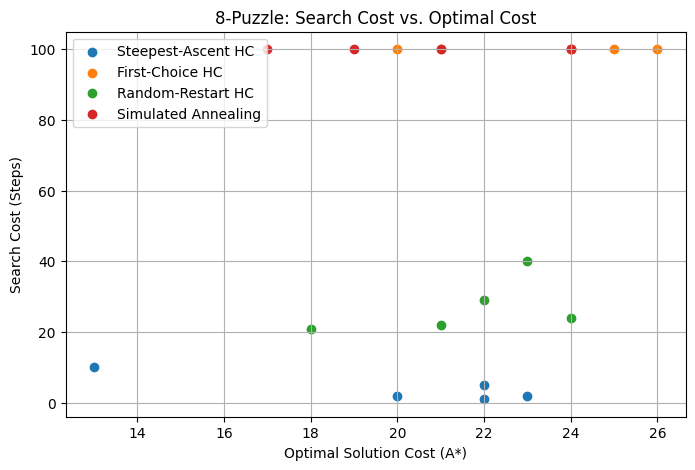

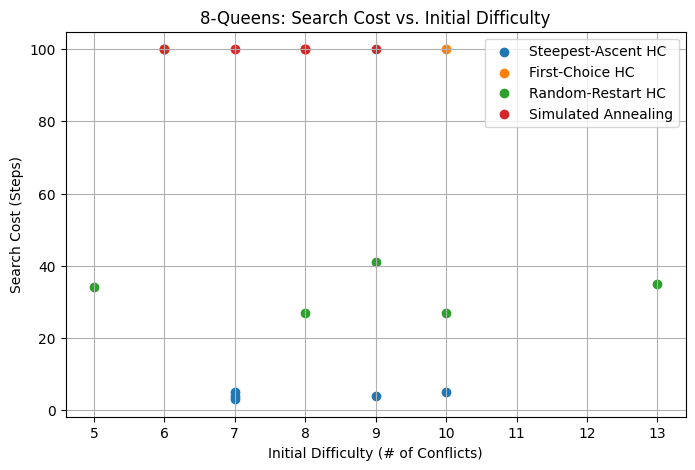

In [22]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# From aima3.search
from aima3.search import (
    Problem, Node, exp_schedule, argmax_random_tie, astar_search
)

# -------------------------------------------------------------------
# RandomEightPuzzle
# -------------------------------------------------------------------
class RandomEightPuzzle(Problem):
    def __init__(self):
        self.goal = (1, 2, 3, 4, 5, 6, 7, 8, 0)
        initial_list = list(self.goal)
        while True:
            random.shuffle(initial_list)
            if self.check_solvability(initial_list):
                break
        initial_state = tuple(initial_list)
        super().__init__(initial=initial_state, goal=self.goal)
    
    def actions(self, state):
        blank_index = state.index(0)
        row, col = divmod(blank_index, 3)
        possible = []
        if row > 0:
            possible.append('UP')
        if row < 2:
            possible.append('DOWN')
        if col > 0:
            possible.append('LEFT')
        if col < 2:
            possible.append('RIGHT')
        return possible

    def result(self, state, action):
        blank_index = state.index(0)
        new_state = list(state)
        if action == 'UP':
            swap = blank_index - 3
        elif action == 'DOWN':
            swap = blank_index + 3
        elif action == 'LEFT':
            swap = blank_index - 1
        elif action == 'RIGHT':
            swap = blank_index + 1
        else:
            raise ValueError("Invalid action")
        new_state[blank_index], new_state[swap] = new_state[swap], new_state[blank_index]
        return tuple(new_state)

    def goal_test(self, state):
        return state == self.goal

    def check_solvability(self, state):
        inversion = 0
        for i in range(len(state)):
            for j in range(i + 1, len(state)):
                if state[i] and state[j] and state[i] > state[j]:
                    inversion += 1
        return (inversion % 2) == 0

    def h(self, node):
        # Manhattan distance
        state = node.state
        distance = 0
        for tile in range(1, 9):
            index_current = state.index(tile)
            row_c, col_c = divmod(index_current, 3)
            index_goal = self.goal.index(tile)
            row_g, col_g = divmod(index_goal, 3)
            distance += abs(row_c - row_g) + abs(col_c - col_g)
        return distance


# -------------------------------------------------------------------
# RandomNQueens
# -------------------------------------------------------------------
class RandomNQueens(Problem):
    def __init__(self, N=8):
        self.N = N
        initial = [random.randint(0, N-1) for _ in range(N)]
        super().__init__(initial=tuple(initial))

    def actions(self, state):
        acts = []
        for col in range(self.N):
            current_row = state[col]
            for row in range(self.N):
                if row != current_row:
                    acts.append((col, row))
        return acts
    
    def result(self, state, action):
        col, new_row = action
        new_state = list(state)
        new_state[col] = new_row
        return tuple(new_state)

    def goal_test(self, state):
        # If there are no conflicts, we have a solution
        return self.conflicts(state) == 0

    def conflicts(self, state):
        # Count number of attacking queen pairs
        c = 0
        for c1 in range(len(state)):
            for c2 in range(c1 + 1, len(state)):
                if state[c1] == state[c2]:
                    c += 1
                elif abs(state[c1] - state[c2]) == abs(c1 - c2):
                    c += 1
        return c

    def h(self, node):
        return self.conflicts(node.state)


# -------------------------------------------------------------------
# Search Algorithm Wrappers
# -------------------------------------------------------------------
def steepest_ascent_hill_climbing(problem, **kwargs):
    current = Node(problem.initial)
    steps = 0
    while True:
        neighbors = current.expand(problem)
        steps += 1
        if not neighbors:
            return current.state, steps
        neighbor = argmax_random_tie(neighbors, key=lambda node: -problem.h(node))
        if problem.h(neighbor) >= problem.h(current):
            return current.state, steps
        current = neighbor

def first_choice_hill_climbing(problem, max_attempts=100, **kwargs):
    current = Node(problem.initial)
    steps = 0
    for _ in range(max_attempts):
        neighbors = current.expand(problem)
        steps += 1
        if not neighbors:
            return current.state, steps
        neighbor = random.choice(neighbors)
        if problem.h(neighbor) < problem.h(current):
            current = neighbor
    return current.state, steps

def random_restart_hill_climbing(problem_class, inner_algo, restarts=10, **kwargs):
    best = None
    best_h = float('inf')
    total_steps = 0
    for _ in range(restarts):
        prob = problem_class()
        solution, steps = inner_algo(prob, **kwargs)
        total_steps += steps
        if solution is not None:
            h_val = prob.h(Node(solution))
            if prob.goal_test(solution) and h_val < best_h:
                best = solution
                best_h = h_val
    return best, total_steps

def simulated_annealing_wrapper(problem, schedule=exp_schedule(), **kwargs):
    current = Node(problem.initial)
    steps = 0
    for t in range(1000):
        T = schedule(t)
        if T == 0:
            return current.state, steps
        neighbors = current.expand(problem)
        steps += 1
        if not neighbors:
            return current.state, steps
        next_choice = random.choice(neighbors)
        delta_e = problem.h(current) - problem.h(next_choice)
        if delta_e > 0 or random.random() < np.exp(delta_e / T):
            current = next_choice
    return current.state, steps


# -------------------------------------------------------------------
# Helper for Optimal Cost (8-Puzzle)
# -------------------------------------------------------------------
def compute_optimal_cost_8puzzle(problem):
    result = astar_search(problem)
    if result is not None:
        return result.path_cost
    else:
        return None


# -------------------------------------------------------------------
# Experiment Runners
# -------------------------------------------------------------------
def run_experiment_8puzzle(algorithm_fn, num_instances=10, compute_opt=True):
    records = []
    for i in range(num_instances):
        prob = RandomEightPuzzle()
        if compute_opt:
            opt_cost = compute_optimal_cost_8puzzle(prob)
        else:
            opt_cost = None

        sol, steps = algorithm_fn(prob)
        
        # Check if sol is None
        if sol is None:
            solved = False
            alg_cost = None
        else:
            solved = prob.goal_test(sol)
            alg_cost = prob.h(Node(sol))  # Usually 0 if solved

        records.append({
            'instance': i,
            'optimal_cost': opt_cost,
            'algorithm_cost': alg_cost,
            'steps': steps,
            'solved': solved
        })
    return records

def run_experiment_nqueens(algorithm_fn, num_instances=10):
    records = []
    for i in range(num_instances):
        prob = RandomNQueens(8)
        initial_difficulty = prob.h(Node(prob.initial))

        sol, steps = algorithm_fn(prob)
        
        # Check if sol is None
        if sol is None:
            solved = False
            alg_cost = None
        else:
            solved = prob.goal_test(sol)
            alg_cost = prob.h(Node(sol))

        records.append({
            'instance': i,
            'initial_difficulty': initial_difficulty,
            'algorithm_cost': alg_cost,
            'steps': steps,
            'solved': solved
        })
    return records


# -------------------------------------------------------------------
# Define and Run Experiments
# -------------------------------------------------------------------
algorithms = {
    "Steepest-Ascent HC": lambda p: steepest_ascent_hill_climbing(p),
    "First-Choice HC": lambda p: first_choice_hill_climbing(p),
    "Random-Restart HC": lambda p: random_restart_hill_climbing(RandomEightPuzzle, steepest_ascent_hill_climbing),
    "Simulated Annealing": lambda p: simulated_annealing_wrapper(p)
}

# 8-Puzzle
results_8puzzle = {}
for name, algo in algorithms.items():
    print(f"Running {name} on 8-Puzzle...")
    recs = run_experiment_8puzzle(algo, num_instances=5, compute_opt=True)
    results_8puzzle[name] = recs

dfs_8puzzle = {name: pd.DataFrame(data) for name, data in results_8puzzle.items()}

# N-Queens
results_nqueens = {}
for name, algo in algorithms.items():
    print(f"Running {name} on 8-Queens...")
    recs = run_experiment_nqueens(algo, num_instances=5)
    results_nqueens[name] = recs

dfs_nqueens = {name: pd.DataFrame(data) for name, data in results_nqueens.items()}


# -------------------------------------------------------------------
# Results
# -------------------------------------------------------------------
print("\n=== 8-Puzzle Results (Sample) ===")
for name, df in dfs_8puzzle.items():
    print(f"\nAlgorithm: {name}")
    print(df)

print("\n=== 8-Queens Results (Sample) ===")
for name, df in dfs_nqueens.items():
    print(f"\nAlgorithm: {name}")
    print(df)

# -------------------------------------------------------------------
# Plots
# -------------------------------------------------------------------
import matplotlib.pyplot as plt

# 8-Puzzle Plot
plt.figure(figsize=(8, 5))
for name, df in dfs_8puzzle.items():
    df_valid = df[df['optimal_cost'].notnull()]
    plt.scatter(df_valid['optimal_cost'], df_valid['steps'], label=name)
plt.xlabel("Optimal Solution Cost (A*)")
plt.ylabel("Search Cost (Steps)")
plt.title("8-Puzzle: Search Cost vs. Optimal Cost")
plt.legend()
plt.grid(True)
plt.show()

# 8-Queens Plot
plt.figure(figsize=(8, 5))
for name, df in dfs_nqueens.items():
    plt.scatter(df['initial_difficulty'], df['steps'], label=name)
plt.xlabel("Initial Difficulty (# of Conflicts)")
plt.ylabel("Search Cost (Steps)")
plt.title("8-Queens: Search Cost vs. Initial Difficulty")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

In conclusion, this study has provided a comprehensive analysis of the performance of hill climbing (steepest-ascent and first-choice), hill climbing with random restart, and simulated annealing algorithms in solving the 8-puzzle and 8-queens problems. Our empirical results, presented in graphical form, illustrate the trade-offs between solution quality, search cost, and success rate for each algorithm.

We observed that while basic hill climbing variants are computationally efficient, they often get trapped in local optima, resulting in suboptimal solutions or failure to find a solution at all. Hill climbing with random restart demonstrated improved success rates by mitigating the local optima issue, albeit at a higher computational cost. Simulated annealing emerged as the most robust algorithm, consistently finding near-optimal solutions across a range of problem complexities, though it demanded the highest computational resources.


## Future Work

The findings of this report underscore the importance of selecting an appropriate search algorithm based on the specific requirements of the problem domain. For problems where solution quality is paramount and computational resources are ample, simulated annealing proves to be the most effective. Conversely, for scenarios demanding quick solutions with limited resources, hill climbing with random restart offers a viable compromise. Future work could explore hybrid approaches, combining the strengths of these algorithms, or investigate the impact of different parameter tunings on their performance. Additionally, extending this analysis to larger problem instances would further enrich our understanding of these search methodologies.


## Bibliography

[1]“Introduction to Hill Climbing | Artificial Intelligence,” GeeksforGeeks, Dec. 12, 2017. https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/
‌[2]baeldung, “Simulated Annealing Explained | Baeldung on Computer Science,” www.baeldung.com, Mar. 26, 2023. https://www.baeldung.com/cs/simulated-annealing
